<a href="https://colab.research.google.com/github/vanderbilt-data-science/ai_summer/blob/main/3_2_datasets_for_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Custom Datasets for Fine Tuning Large Language Models

Most of the prep work invovled in fine tuning a large language model often comes before the actual training. Preparing the data and ensuring that it is in the correct format for the model you are trying to train is very important. In this notebook, we'll examine how to prepare your data for fine tuning Google's Gemma model.

First, lets take a look at the different types of data you may need at each stage of training a large language model.

## Stages of Training

### Pretraining (Self-Supervised Learning)

Training an untrained model with randomized weights
* Training data is unlabeled
* Raw text is automatically pre-processed for training
* Training methods include:
  * Masked Language Modeling
  * Causal Language Modeling

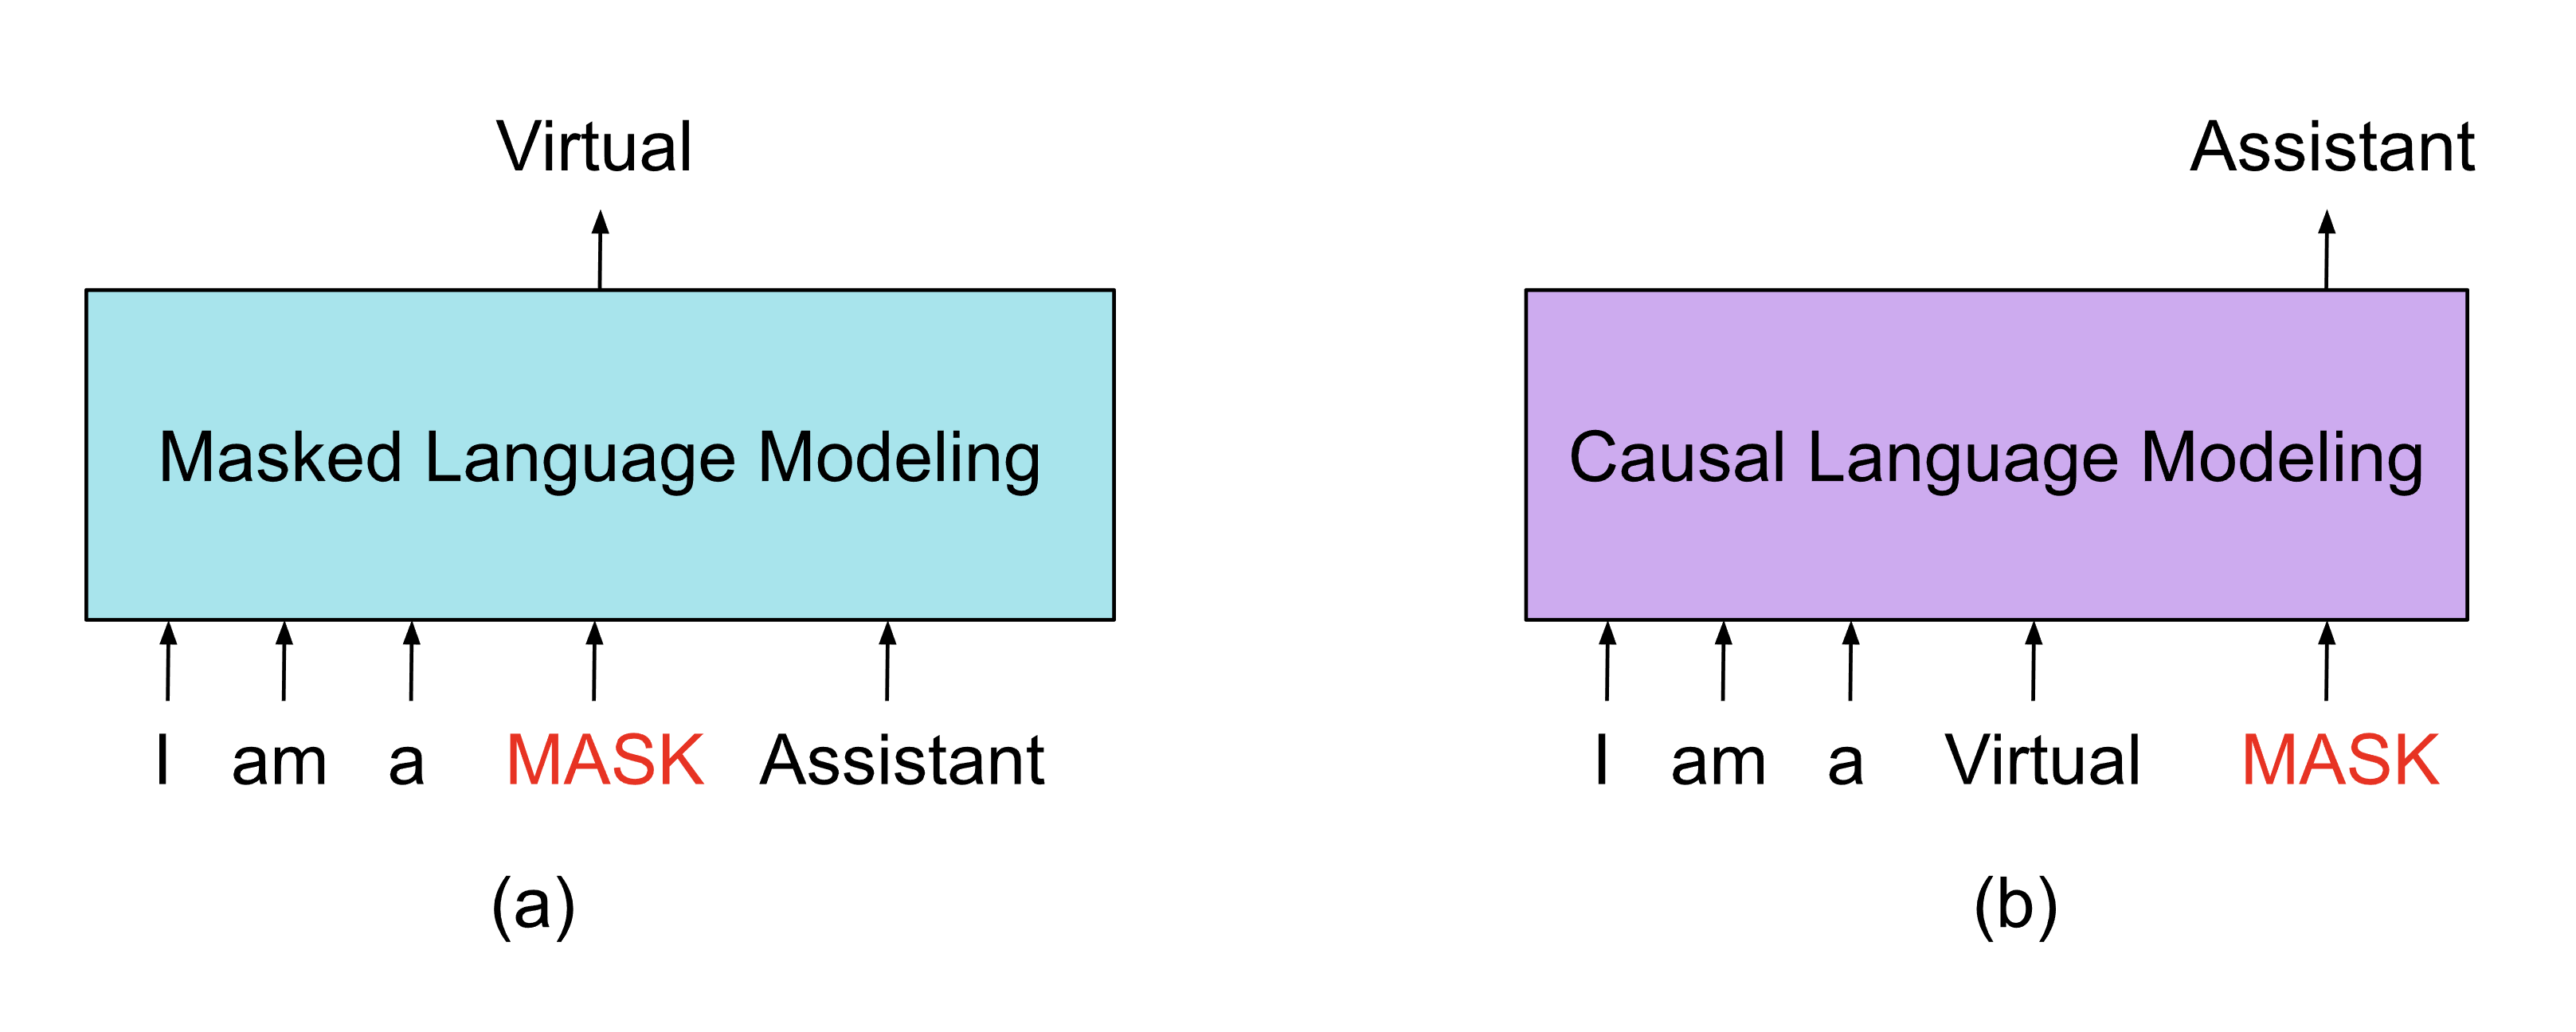

### Alignment (Supervised Learning)

* Reinforcement Learning from Human Feedback (RLHF)
* Need a dataset of multiple outputs for each prompt with a human rating/accepted/rejected.


### Finetuning (Supervised Learning)

* Domain Adaptation
* Instruction fine tuning
* Datasets of prompt-response pairs. This could include:
	* Translation tasks
	* Coding prompts
	* Q&A

  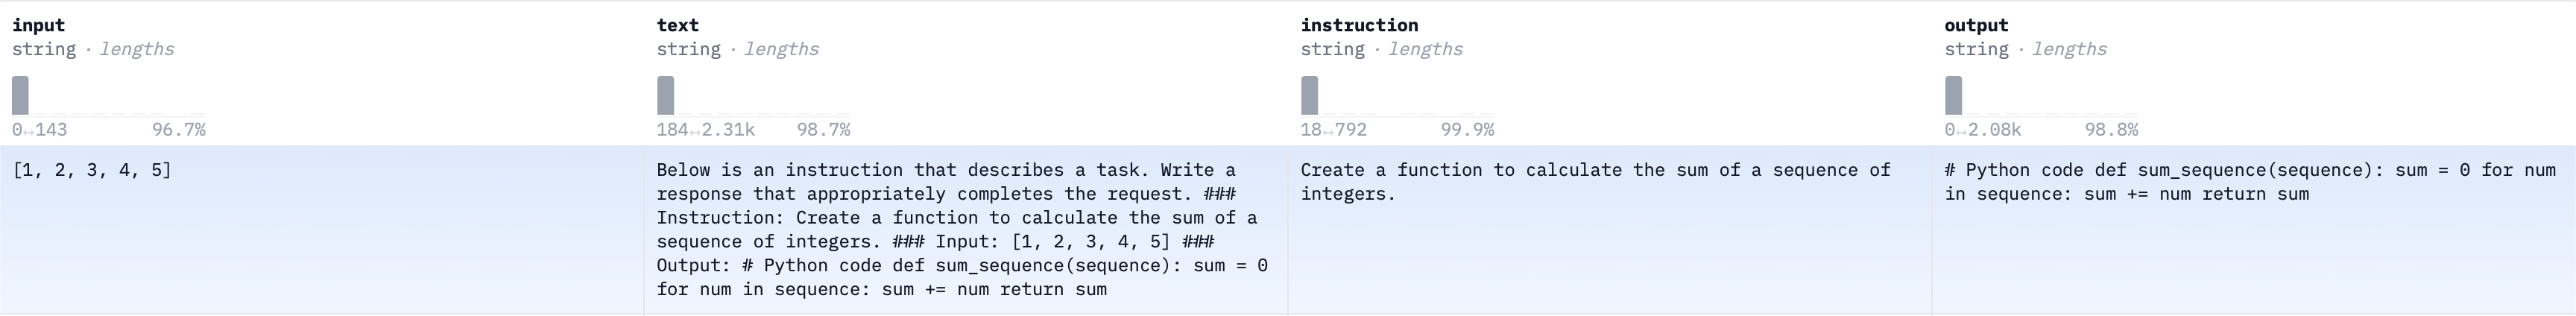

In the next section, we will examine a few ways to prepare custom datasets for finetuning large langauge models for specific tasks.

# Environment Setup

In this section we'll install all necessary packages and load the 7B parameter version of Gemma.

In [7]:
!pip install -q -U transformers
!pip install accelerate
!pip install datasets
!pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple/


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Create a bits and bytes configuration to download a quantized version of the model

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

To complete the next step, you will require a HuggingFace token. If you do not have this, you can create one [here](https://huggingface.co/settings/tokens). If you do not have an account, you can [create a HuggingFace account here](https://huggingface.co/).

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
#model_id = "google/gemma-7b-it"
#model_id = "google/gemma-7b"
# model_id = "google/gemma-2b-it"
model_id = "google/gemma-2b"

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

# Loading the Tutorial Dataset

Instruction Fine Tuning, as the name suggests, requries that your data look like a set of instructions for the model to follow.

A good example of this is the dataset provided by TokenBender on HuggingFace called code_instructions_122k_alapaca_style. This dataset is excellent for fine tuning a large language model for code generation. Let's take a look at one sample of data from this dataset:

In [13]:
from datasets import load_dataset

dataset = load_dataset("TokenBender/code_instructions_122k_alpaca_style", split="train")

df = dataset.to_pandas()
df.head()

,input,text,instruction,output
0,"[1, 2, 3, 4, 5]",Below is an instruction that describes a task....,Create a function to calculate the sum of a se...,# Python code\ndef sum_sequence(sequence):\n ...
1,"str1 = ""Hello ""\nstr2 = ""world""",Below is an instruction that describes a task....,Develop a function that will add two strings,"def add_strings(str1, str2):\n """"""This func..."
2,,Below is an instruction that describes a task....,Design a data structure in C++ to store inform...,#include <map>\n#include <string>\n\nclass Gro...
3,"[3, 1, 4, 5, 9, 0]",Below is an instruction that describes a task....,Implement a sorting algorithm to sort a given ...,def bubble_sort(arr):\n n = len(arr)\n \n ...
4,Not applicable,Below is an instruction that describes a task....,Design a Swift application for tracking expens...,import UIKit\n\nclass ExpenseViewController: U...


As you can see, this dataset contains 4 columns; text, instruction, input, and output.

The text column in this dataset is simply all other columns concatenated together. The instruction column contains the query, the input columns includes any inputs that would be necessary to complete the prompt, and the output contains the desired response.

You have some level of flexibility when it comes to the exact structure of the dataset, but in general, you need to have at least one set of inputs and one set of outputs, where the input is some set of instructions that should result in the content of the output column.

Creating input and output pairs using your existing unstructured text data is the first step in creating your training dataset and can often be the most challenging part of a project.

Here is an example of how we converted two sets of unstructured data in one of our projects from this semester into a dataset (almost) ready for fine tuning.

We had several texts in Medieval French and their translations into English, small sections at a time. With the help of ChatGPT, we were able to easily develop a script to convert these two documents into an appropritate dataset.

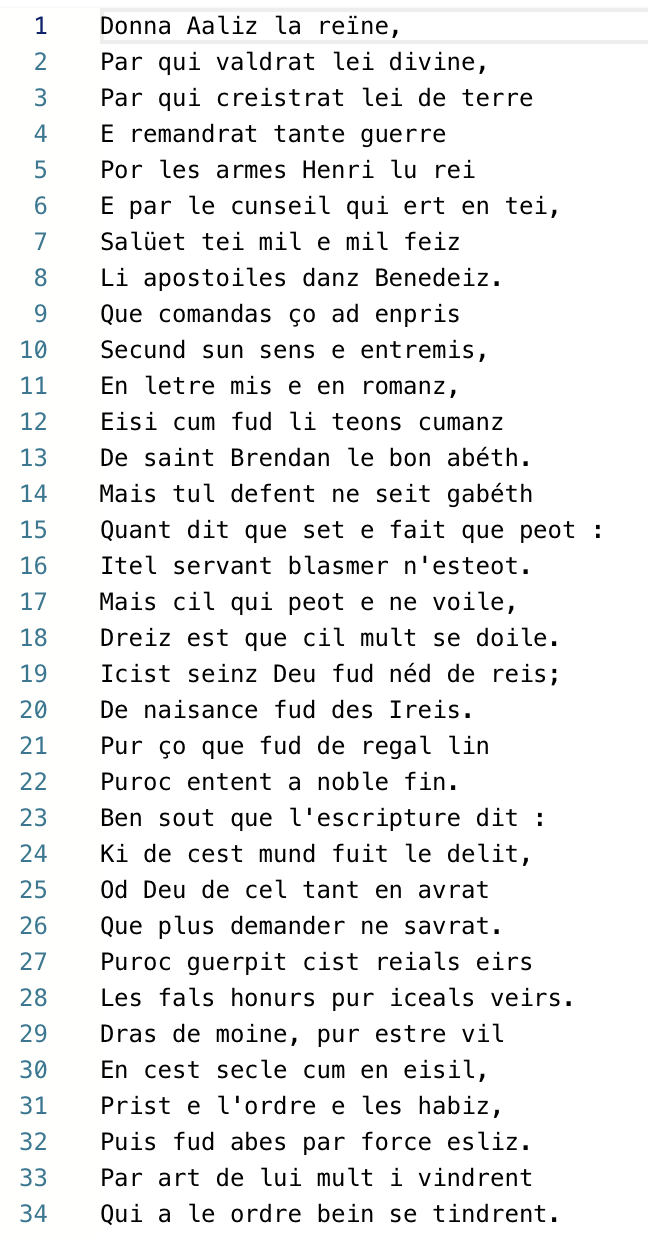



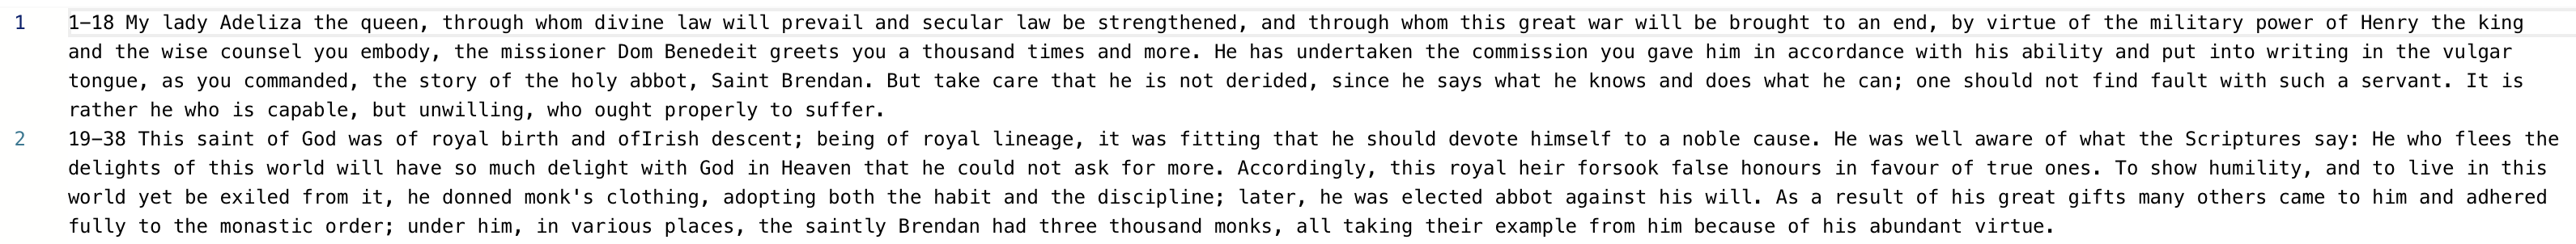

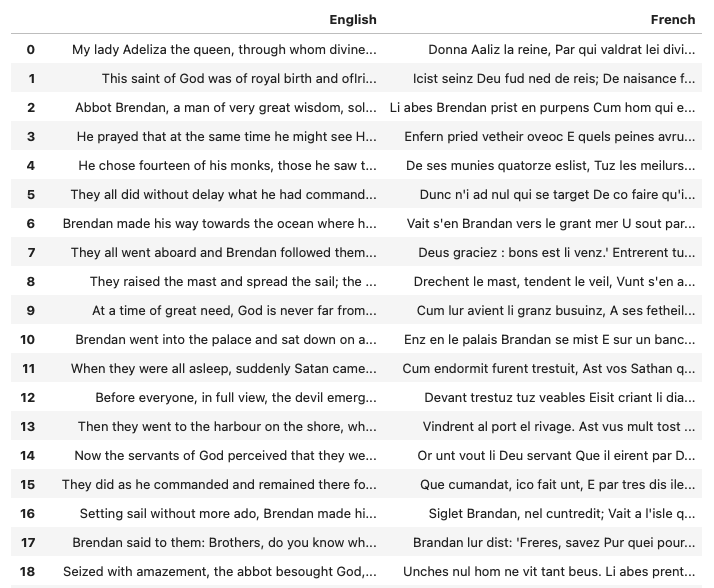

# Formatting the Dataset

Every Large Language Model has its own format for instructions. These instructions tend to be fairly similar, but often contain some minor modifications to the instruction template. Here is the formatting template for Gemma:

```
<start_of_turn>user What is your favorite condiment? <end_of_turn>
<start_of_turn>model Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavor to whatever I'm cooking up in the kitchen!<end_of_turn>
```

In [14]:
def generate_prompt(data_point):
    """Gen. input text based on a prompt, task instruction, (context info.), and answer

    :param data_point: dict: Data point
    :return: dict: tokenzed prompt
    """
    prefix_text = 'Below is an instruction that describes a task. Write a response that ' \
               'appropriately completes the request.\n\n'
    # Samples with additional context into.
    if data_point['input']:
        text = f"""<start_of_turn>user {prefix_text} {data_point["instruction"]} here are the inputs {data_point["input"]} <end_of_turn>\n<start_of_turn>model {data_point["output"]} <end_of_turn>"""
    # Without
    else:
        text = f"""<start_of_turn>user {prefix_text} {data_point["instruction"]} <end_of_turn>\n<start_of_turn>model {data_point["output"]} <end_of_turn>"""
    return text

# add the "prompt" column in the dataset
text_column = [generate_prompt(data_point) for data_point in dataset]
dataset = dataset.add_column("prompt", text_column)

In [15]:
df.head(1)

,input,text,instruction,output
0,"[1, 2, 3, 4, 5]",Below is an instruction that describes a task....,Create a function to calculate the sum of a se...,# Python code\ndef sum_sequence(sequence):\n ...


In [16]:
dataset[0]['prompt']

'<start_of_turn>user Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n Create a function to calculate the sum of a sequence of integers. here are the inputs [1, 2, 3, 4, 5] <end_of_turn>\n<start_of_turn>model # Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum <end_of_turn>'

```
<start_of_turn>user Below is an instruction that describes a task. Write a response that appropriately completes the request.

 Create a function to calculate the sum of a sequence of integers. here are the inputs [1, 2, 3, 4, 5] <end_of_turn>
<start_of_turn>model # Python code
def sum_sequence(sequence):
  sum = 0
  for num in sequence:
    sum += num
  return sum <end_of_turn>
```

Now you have successfully created a dataset that is ready to use for finetuning Gemma. For other open source LLMs like Llama2, Mistral, Falcon etc. please refer to their model pages on HuggingFace for guides on how to format your data.

Training Image Models: https://huggingface.co/docs/transformers/v4.38.2/en/tasks/object_detection


Training Audio Models: https://huggingface.co/docs/transformers/v4.38.2/en/tasks/audio_classification

References: https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c, https://huggingface.co/google/gemma-7b-it